# Исследование данных о продаже квартир в Санкт-Петербурге

### Описание задачи

Имеются данные Яндекс Недвижимости — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Необходимо научиться определять рыночную стоимость объектов недвижимости.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Загрузка данных и изучение общей информации о них

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Считывание датасета
data = pd.read_csv('real_estate_data.csv', sep='\t', decimal='.')

**Описание данных**
- `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)  

- `balcony` — число балконов  

- `ceiling_height` — высота потолков (м)  

- `cityCenters_nearest` — расстояние до центра города (м)  

- `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)  

- `first_day_exposition` — дата публикации  

- `floor` — этаж  

- `floors_total` — всего этажей в доме  

- `is_apartment` — апартаменты (булев тип)  

- `kitchen_area` — площадь кухни в квадратных метрах (м²)  

- `last_price` — цена на момент снятия с публикации  

- `living_area` — жилая площадь в квадратных метрах (м²)  

- `locality_name` — название населённого пункта  

- `open_plan` — свободная планировка (булев тип)  

- `parks_around3000` — число парков в радиусе 3 км  

- `parks_nearest` — расстояние до ближайшего парка (м)  

- `ponds_around3000` — число водоёмов в радиусе 3 км  

- `ponds_nearest` — расстояние до ближайшего водоёма (м)  

- `rooms` — число комнат  

- `studio` — квартира-студия (булев тип)  

- `total_area` — общая площадь квартиры в квадратных метрах (м²)  

- `total_images` — число фотографий квартиры в объявлении

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Видно, что в большинстве колонок имеются пропущенные значения, причем где-то их доля близка аж к 90%! Однако, скорее всего, эти пропуски имеют разную природу. Например, пропуски в колонке `ponds_nearest` могут означать отсутствие водоемов в радиусе 3 км, а пропуски в колонке `living_area` могли возникнуть из-за того, что не все считают именно жилую площадь, кто-то указывает только общую площадь квартиры

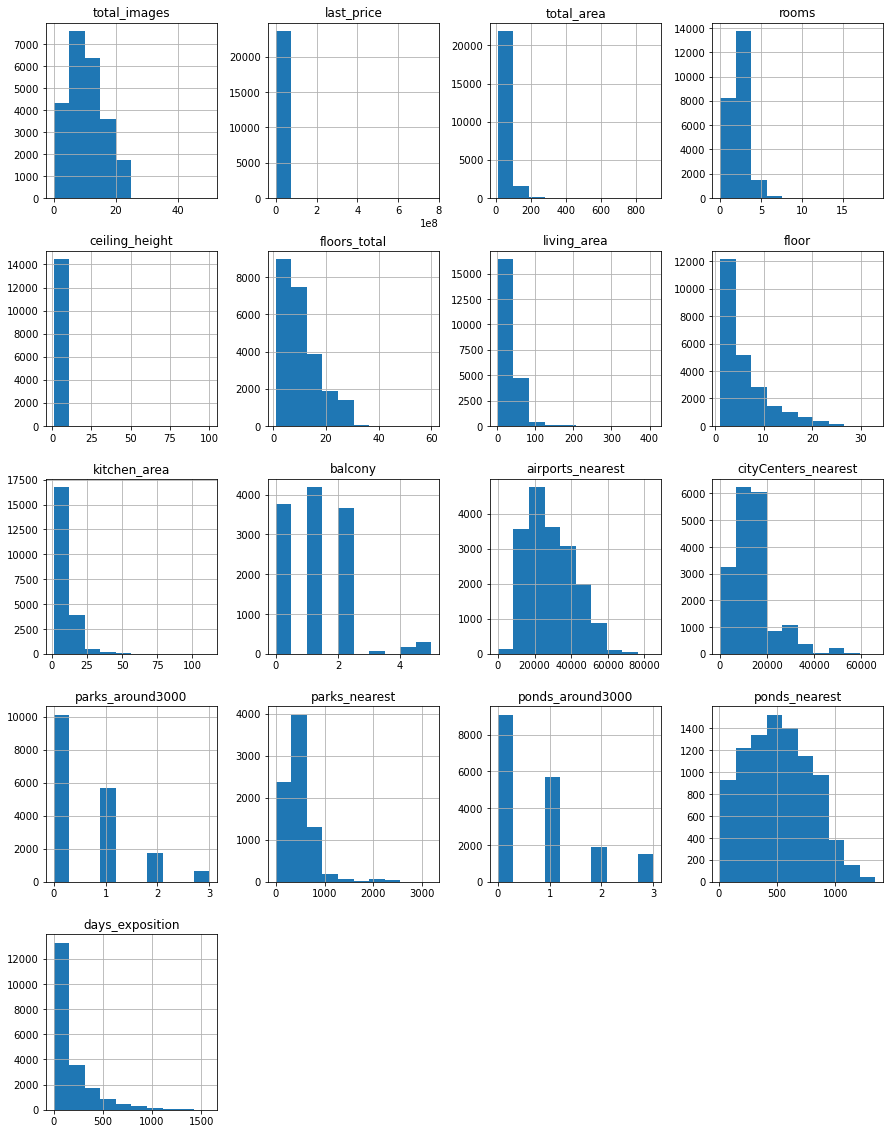

In [4]:
data.hist(figsize=(15, 20))
plt.show()

Из построенных графиков видно, что
* для большинства объектов недвижимости было выложено 5-10 фотографий
* итоговая цена на каждый объект не превышала 100 млн рублей
* что касается общей площади, логично, что она обычно не превышает 100 м²
* жилплощадь обычно лежит в пределах 50 м
* площадь кухни обычно составляет до 10 м²
* обычное количество комнат - около 3
* про высоту потолков не превышает 10 м
* количество этажей в зданиях разное, однако в подавляющем большинстве зданий это количество не превосходит 10, номер этажа тоже чаще всего лежит в пределах 10, редко кто живет выше
* в большинстве объектов количество балконов меньше 3
* чаще всего аэропорты и центры городов расположены в радиусе 20 км от объектов недвижимости
* видно, что парков и водоемов рядом с объектами часто просто нет, причем, скорее всего, много парков расположено рядом с водоемами, что отчасти подтверждается тем, что в среднем расстояние до ближайшего парка равно расстоянию до ближайшего водоема
* ну и понятно, что большинство объявлений висит сравнительно недолго, около полугода

### Предобработка данных

#### Обработка пропусков

In [5]:
# Еще раз выведем информацию о датафрейме, чтобы подробнее изучить пропуски
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Пропуски есть в большинстве столбцов. Начнем обработку с тех столбцов, в которых можно найти логичную замену.

In [6]:
# Пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Количество пропусков' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('Пропусков не осталось :) ')

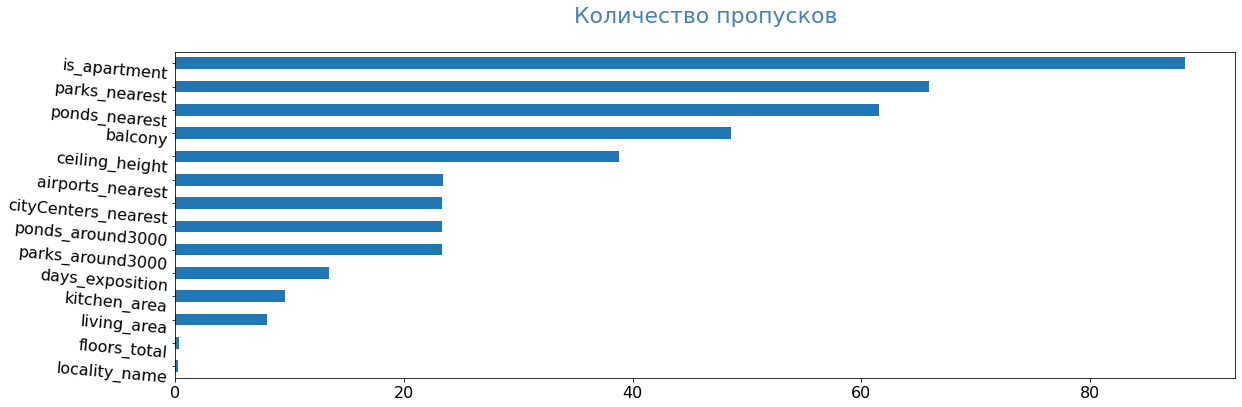

In [7]:
pass_value_barh(data)

Пропуски в стобце `balcony` можно интерпретировать как отсутствие балконов: если продавец не указал количество балконов, то, скорее всего, их просто нет.

In [8]:
data['balcony'] = data['balcony'].fillna(0)

Наличие пропусков в столбце `is_apartment` можно объяснить похожим образом: если соответствующее поле не заполнено, то, скорее всего, данный объект недвижимости не является апартаментами. Причем в этой колонке всего 2800 значений из 24000, а это тоже довольно логично: гораздо чаще продают обычные квартиры и прочую недвижимость, апартаменты все-таки являются некоторой роскошью.

In [9]:
data['is_apartment'] = data['is_apartment'].fillna(False)

Что касается столбцов `airports_nearest` и `cityCenters_nearest`. Вполне возможно, что объекты недвижимости, у которых в этих колонках стоят пропуски, находятся где-то в сельской местности Ленинградской области, причем не близко к Санкт-Петербургу. Тогда центр города и ближайший аэропорт могут находиться очень далеко от этих объектов. Также вероятно, что часть объектов находится в каких-то городах Ленинградской области: аэропортов там нет, зато центр города близко. Всего в каждой из этих колонок около 5000 пропусков. Заполнить можем только пропуски в тех строках, где в колонке с местностью стоит Санкт-Петербург, для этого будем использовать медианные значения. Аналогичная ситуация и с водоемами и парками (столбцы `ponds_nearest` и `parks_nearest`).

Теперь несколько слов о пропусках в столбцах с данными о площади. Общая площадь объекта указывалась всегда. Отсутствуют лишь значения площади кухни и жилплощади. Их можно попытаться восстановить следующим образом: посчитать среднее отношение площади кухни к площади всей квартиры и использовать получившийся коэффициент для заполнения пропусков. Однако это может привести к нарушению здравого смысла: если в итоге сумма площади кухни и жилплощади будет больше 90% общей площади квартиры (а оставшиеся 10% необходимы на коридоры, санузлы, балконы итд). В этом случае будем поступать так: рассчитаем коэффициент масштабирования k, для этого получившуюся суммарную площадь поделим на 0.9 (чтобы площадь кухни и жилплощадь составляли 90% какой-то общей площади), потом найдем отношение истинной общей площади квартиры к получившейся площади. Это и будет коэффициент k. После этого умножим значения площади кухни и жилплощади на k. Таким образом мы и пропуски заполним, и здравый смысл не нарушим.

###### kitchen_area

In [10]:
# Начнем со столбца, содержащего данные о площади кухни
data.groupby('rooms')['kitchen_area'].median()

rooms
0        NaN
1       9.04
2       8.80
3       9.50
4      11.10
5      15.10
6      19.50
7      20.00
8      25.00
9      14.30
10     19.80
11     12.60
12    112.00
14     21.25
15    100.00
16     13.00
19     27.60
Name: kitchen_area, dtype: float64

В квартирах, где нет комнат, медиана - NaN. Вполне возможно, что часть из них (если не все) являются студиями или открытыми планировками. В таких квартирах кухонь просто нет. Но в любом случае в них есть какое-то пространство для готовки и так далее. Заполним эти пропуски минимальным значением площади кухни-ниши - 5 кв м.

In [11]:
data.loc[(data['rooms'] == 0) & (data['kitchen_area'].isna()), 'kitchen_area'] = 5

Пропуски в остальных типах квартир будем заполнять описанным выше способом

In [12]:
data['kitchen_part'] = data['kitchen_area'] / data['total_area']
mean_kitchen_part = data['kitchen_part'].mean()

data.loc[data['kitchen_area'].isna(), 'kitchen_area'] = data.loc[data['kitchen_area'].isna(), 'total_area'] * mean_kitchen_part

In [13]:
# Проверка, что все пропуски заменены
data['kitchen_area'].isna().sum()

0

###### living_area

In [14]:
# Перейдем теперь к столбцу с жилплощадями
data.groupby('rooms')['living_area'].median()

rooms
0      18.000
1      17.600
2      30.500
3      45.000
4      63.600
5      91.785
6     123.900
7     145.000
8     161.000
9     179.200
10    161.400
11    133.900
12    409.700
14    195.150
15    409.000
16    180.000
19    264.500
Name: living_area, dtype: float64

Заполнять пропуски в этом столбце будем по тому же принципу, что и в столбце с площадью кухни

In [15]:
data['living_part'] = data['living_area'] / data['total_area']
mean_living_part = data['living_part'].mean()

data.loc[data['living_area'].isna(), 'living_area'] = data.loc[data['living_area'].isna(), 'total_area'] * mean_living_part

In [16]:
# Проверка, что все пропуски заменены
data['living_area'].isna().sum()

0

Выполним проверку на соответствие данных здравому смыслу. Для этого посмотрим на количество квартир, в которых площадь кухни и жилплощадь суммарно составляют более 90% общей площади. Если такие есть, обработаем их.

In [17]:
# Количество квартир, в которых в результате заполнения пропусков площадь кухни и жилплощадь в сумме 
# составляют больше 90% общей площади квартиры
data[data['total_area'] * 0.9 <= (data['living_area'] + data['kitchen_area'])].shape[0]

698

In [18]:
# Функция для исправления противоречащих здравому смыслу значений сумм жилплощади и площади кухни
def missing_area_fill(total, kitchen, living):
    if kitchen > 5:
        kitchen_living_area = kitchen + living
        new_total_area = kitchen_living_area / 0.9

        k = total / new_total_area

        living_area = int(living * k)
        kitchen_area = int(kitchen * k)
        return kitchen_area, living_area
    else:
        kitchen_area = 5
        living_area = int(total - kitchen_area - total * 0.1)
        return kitchen_area, living_area

Пояснение к работе функции. Первый блок я описал выше, там, где описывал принцип заполнения пропусков. А второй блок несет следующий смысл: минимальный допустимы размер кухни - 5 кв м (кухня-ниша), соответственно, если среди новоявленных аномалий есть такие, в которых площадь кухни 5 кв м, а общая площадь меньше суммы площади кухни и жилплощади, то при приведении этих данных в порядок, размер кухни уменьшать нельзя, поэтому уменьшаем только размер жилплощади

In [19]:
indexes = data[data['total_area'] * 0.9 <= (data['living_area'] + data['kitchen_area'])].index
for i in indexes:
    row = data.iloc[i]
    kitchen, living = missing_area_fill(row.loc['total_area'], row.loc['kitchen_area'], row.loc['living_area'])
    data.loc[i, 'kitchen_area'] = kitchen
    data.loc[i, 'living_area'] = living

In [20]:
# Проверка
data[data['total_area'] * 0.9 < (data['living_area'] + data['kitchen_area'])].shape[0]

0

###### locality_name

Разберемся с пропусками в столбце `locality_name`. Здесь пропущено всего 49 значений. Причем, скорее всего, раз местность пропущена, то объект находится не в Санкт-Петербурге. Так как 49 строк - это всего 0.2% от общего количества данных, то можно просто удалить эти строки. Кстати, в части из них также есть пропуски в колонках `airports_nearest`, `cityCenters_nearest`, `parks_nearest` или `ponds_nearest`, а это подтверждает мысль о том, что, скорее всего, данные объекты находятся не в Санкт-Петербурге.

In [21]:
(
    data.loc[
        data['locality_name'].isna() & 
        (
            data['airports_nearest'].isna() | 
            data['cityCenters_nearest'].isna() | 
            data['parks_nearest'].isna() | 
            data['ponds_nearest'].isna()
        ), 
        :].head()
)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_part,living_part
1097,3,8600000.0,81.7,2016-04-15T00:00:00,3,3.55,5.0,50.8,2,False,...,NaN,23478.0,4258.0,0.0,NaN,0.0,NaN,147.0,0.107711,0.621787
2033,6,5398000.0,80.0,2017-05-30T00:00:00,3,NaN,4.0,42.6,2,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.0,0.232500,0.532500
2603,20,3351765.0,42.7,2015-09-20T00:00:00,1,NaN,24.0,15.6,3,False,...,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,276.0,0.250585,0.365340
2632,2,5130593.0,62.4,2015-10-11T00:00:00,2,NaN,24.0,33.1,21,False,...,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,256.0,0.131410,0.530449
3574,10,4200000.0,46.5,2016-05-28T00:00:00,2,NaN,5.0,30.8,5,False,...,NaN,27419.0,8127.0,0.0,NaN,1.0,603.0,45.0,0.139785,0.662366


In [22]:
data = data.loc[~data['locality_name'].isna()].reset_index(drop=True)

In [23]:
sum(data['locality_name'].isna())

0

###### parks_around3000 и ponds_around3000

Теперь посмотрим на столбцы, содержащие информацию о количестве парков и водоемов в радиусе 3 км от объекта. В этих колонках примерно по 6000 пропусков. Вполне возможно, что объекты, о которых информация этого рода пропущена, находятся вне Петербурга, например, где-то в сельской местности. А там парки - довольно редкое явление. Поэтому пропуски в этих столбцах уместно заменить на 0.

In [24]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

###### ceiling_height

Разберемся теперь с пропусками в столбце `ceiling_height`, содержащем данные о высоте потолков. Заполним эти пропуски следующим образом: разделим всю недвижимость на две категории по местоположению: в Санкт-Петербурге и не в Санкт-Петербурге, и для каждой группы заполним пропуски медианным значением, предварительно устранив аномальные значения.

Для начала помотрим общее распределение высот

In [25]:
data['ceiling_height'].describe()

count    14490.000000
mean         2.771287
std          1.261593
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Видно, что в этом столбце присутствуют странные значения, например, меньшие 2.5 метров - минимальной высоты по российским стандартам, или большие 4 метров, что аномально высоко. Оценим типичность аномалий для столбца

In [26]:
data[data['ceiling_height'] > 4]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_part,living_part
154,1,8200000.0,80.0,2018-11-06T00:00:00,3,4.15,3.0,44.2000,2,False,...,Санкт-Петербург,20562.0,3167.0,2.0,344.0,1.0,838.0,38.0,0.152500,0.552500
355,17,3600000.0,55.2,2018-07-12T00:00:00,2,25.00,5.0,32.0000,2,False,...,Гатчина,NaN,NaN,0.0,NaN,0.0,NaN,259.0,NaN,0.579710
464,15,66571000.0,280.3,2015-06-11T00:00:00,6,5.20,8.0,159.5000,7,False,...,Санкт-Петербург,26316.0,6655.0,3.0,187.0,1.0,616.0,578.0,0.075276,0.569033
1026,20,155000000.0,310.0,2018-10-12T00:00:00,5,5.30,3.0,190.0000,3,False,...,Санкт-Петербург,24899.0,4785.0,0.0,NaN,1.0,603.0,NaN,0.203226,0.612903
1053,13,550000.0,29.0,2018-02-01T00:00:00,1,5.00,3.0,16.3782,1,False,...,Бокситогорск,NaN,NaN,0.0,NaN,0.0,NaN,6.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22264,20,5300000.0,45.0,2017-09-30T00:00:00,1,10.30,16.0,15.5000,15,False,...,Санкт-Петербург,36353.0,11936.0,2.0,440.0,2.0,450.0,136.0,NaN,0.344444
22291,19,9999000.0,92.4,2019-04-05T00:00:00,2,32.00,6.0,55.5000,5,False,...,Санкт-Петербург,18838.0,3506.0,0.0,NaN,3.0,511.0,NaN,0.178571,0.600649
22448,7,91075000.0,491.0,2017-05-27T00:00:00,5,4.20,9.0,274.0000,9,False,...,Санкт-Петербург,25525.0,5845.0,2.0,116.0,0.0,NaN,115.0,0.091650,0.558045
22822,0,15000000.0,25.0,2018-07-25T00:00:00,1,100.00,5.0,12.0000,5,True,...,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0,0.440000,0.560000


Таких значений около 70 штук. Причем среди них есть значения вроде 27.00 или 32.00, которые, вероятно, возникли из-за ошибки ввода, то есть человек хотел написать 2.7, а вместо этого написал 27. Такие значения уместно поделить на 10 и оставить. Остальные значения, большие 4, удаляем.

In [27]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        14490 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           23650 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          23650 non-null  bool   
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          23650 non-null  float64
 13  balcony               23650 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [28]:
# Исправление значений от 10 до 40 на значения в диапазоне от 1 до 4
for i in data[data['ceiling_height'] > 4].index:
    if 10 <= data['ceiling_height'].iloc[i] <= 40:
        data['ceiling_height'].iloc[i] /= 10

# Удаление объектов, высота потолков которых больше 4 метров
data = data.loc[(data['ceiling_height'] <= 4) | (data['ceiling_height'].isna())].reset_index(drop=True)

C:\Users\gturk\AppData\Local\Temp\ipykernel_18544\2996808482.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ceiling_height'].iloc[i] /= 10


In [29]:
# check
data.shape[0]

23599

Разберемся теперь со значениями от 1 до 2 метров. Это слишком низкие потолки. Посмотрим на их количество.

In [30]:
data[data['ceiling_height'] < 2]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_part,living_part
5686,5,1500000.0,42.8,2017-08-14T00:00:00,2,1.20,2.0,27.5,1,False,...,городской посёлок Мга,NaN,NaN,0.0,NaN,0.0,NaN,248.0,0.121495,0.642523
14998,19,5600000.0,56.4,2018-05-11T00:00:00,2,1.40,14.0,32.4,5,False,...,Санкт-Петербург,14814.0,13610.0,0.0,NaN,0.0,NaN,315.0,0.161348,0.574468
16864,5,4100000.0,40.0,2017-10-17T00:00:00,1,1.75,37.0,17.4,5,False,...,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0,0.208500,0.435000
22215,20,5300000.0,45.0,2017-09-30T00:00:00,1,1.03,16.0,15.5,15,False,...,Санкт-Петербург,36353.0,11936.0,2.0,440.0,2.0,450.0,136.0,NaN,0.344444
22494,16,6000000.0,55.0,2018-10-31T00:00:00,2,1.00,12.0,32.4,7,False,...,Санкт-Петербург,33053.0,14217.0,2.0,293.0,2.0,289.0,13.0,0.181818,0.589091


Таких всего 5 штук. Заменим их на стандартное значение 2.5 метра

In [31]:
data.loc[data['ceiling_height'] < 2, 'ceiling_height'] = 2.5

In [32]:
data[data['ceiling_height'] < 2].shape[0]

0

Итак, аномалии в этом столбце устранены, теперь можно переходить к запонению пропусков.

Вообще говоря, высота потолков - это параметр, который, скорее всего, слабо влияет на стоимость квартиры. Поэтому в данном случае можно заменить пропуски на 0 и добавить индикаторный столбец булевого типа (1 - пропуск, 0 - не пропуск). Разделение на два столбца произведем, чтобы сохранить тип данных колонки.

In [33]:
data['ceiling_height'].isna().sum()

9160

In [34]:
data['ceiling_height_missing'] = 0
data.loc[data['ceiling_height'].isna(), 'ceiling_height_missing'] = 1
data.loc[data['ceiling_height'].isna(), 'ceiling_height'] = 0

In [35]:
# Проверка, что пропуски обработаны
data['ceiling_height_missing'].value_counts()

0    14439
1     9160
Name: ceiling_height_missing, dtype: int64

###### days_exposition

Разберемся с пропусками в столбце `days_exposition`. Для начала посмотрим на общее распределение данных в этом столбце.

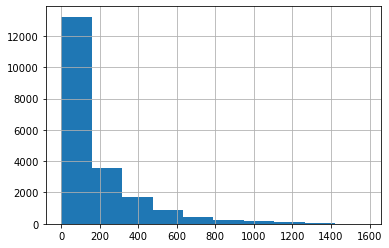

In [36]:
data['days_exposition'].hist();

По гистограмме видно, что большинство объявлений снимаются в течение полугода после публикации. Это вполне правдоподобный срок для продажи квартиры. Однако есть и такие квартиры, которые продавались около 3-х лет. На срок, в который была продана квартира сильнее всего влияет ее местоположение. Ниже приведен список всех мест, где продавалось жилье.

In [37]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Размеры этого списка довольно внушительные, проведем некоторую категоризацию данных по типу местности. Выделим следующие группы: город, поселок городского типа, сельская местность, СНТ (садовые товарищества)

In [38]:
def categorize_locality(x: str):
    if 'деревня' in x or 'село' in x or 'посёлок' in x:
        return 'сельская местность'
    if 'город' in x:
        return 'город'
    if 'садов' in x:
        return 'СНТ'
    return 'город'


data['locality_category'] = data['locality_name'].str.lower().apply(categorize_locality)

In [39]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_part,living_part,ceiling_height_missing,locality_category
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.000000,8,False,...,16028.0,1.0,482.0,2.0,755.0,NaN,0.231481,0.472222,0,город
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,0.00,11.0,18.600000,1,False,...,18603.0,0.0,NaN,0.0,NaN,81.0,0.272277,0.460396,1,сельская местность
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,0.00,5.0,34.300000,4,False,...,13933.0,1.0,90.0,2.0,574.0,558.0,0.148214,0.612500,1,город
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,0.00,14.0,89.797718,9,False,...,6800.0,2.0,84.0,3.0,234.0,424.0,NaN,NaN,1,город
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.000000,13,False,...,8098.0,2.0,112.0,1.0,48.0,121.0,0.410000,0.320000,0,город


Теперь заполним пропуски в столбце `days_exposition` медианными значениями по каждой группе.

In [40]:
# Заполнение пропусков
exposition_stat = data.groupby('locality_category')['days_exposition'].median()
for i in exposition_stat.index:
    data.loc[(data['locality_category'] == i) & (data['days_exposition'].isna()), 'days_exposition'] = exposition_stat.loc[i]

# Проверка, что все пропуски заменены
data['days_exposition'].isna().sum()

0

###### floors_total

И наконец столбец `floors_total`. В нем меньше ста пропусков. Заменить эти пропуски можно опять же медианными значениями, полученными с помощью группировки по количеству этажей по типу местности, в которой находится дом: вряд ли в сельской местности будут многоэтажки, а вот в столичном Питере - запросто. Однако если потом окажется, что у каких-то квартир этажность выше общей этажности дома, просто заменим этажность дома на этажность квартиры. То есть сделаем так, что квартира будет на последнем этаже.

In [41]:
# Заполнение пропусков
floors_stat = data.groupby('locality_category')['floors_total'].median()
for i in floors_stat.index:
    data.loc[(data['locality_category'] == i) & (data['floors_total'].isna()), 'floors_total'] = floors_stat.loc[i]

# Проверка, что все пропуски заменены
data['floors_total'].isna().sum()

0

In [42]:
data.loc[data['floors_total'] < data['floor'], 'floors_total'] = data.loc[data['floors_total'] < data['floor'], 'floor']

###### airports_nearest, cityCenters_nearest, parks_nearest, ponds_nearest

In [43]:
# Считаем медианные значения в каждой колонке
airports_petersburg_median = data.loc[data['locality_name'] == 'Санкт-Петербург', 'airports_nearest'].median()
city_center_petersburg_median = data.loc[data['locality_name'] == 'Санкт-Петербург', 'cityCenters_nearest'].median()
parks_petersburg_median = data.loc[data['locality_name'] == 'Санкт-Петербург', 'parks_nearest'].median()
ponds_petersburg_median = data.loc[data['locality_name'] == 'Санкт-Петербург', 'ponds_nearest'].median()

# Осуществляем замену
data.loc[(data['locality_name'] == 'Санкт-Петербург') & (data['airports_nearest'].isna()), \
         'airports_nearest'] = airports_petersburg_median

data.loc[(data['locality_name'] == 'Санкт-Петербург') & (data['cityCenters_nearest'].isna()), \
         'cityCenters_nearest'] = city_center_petersburg_median

data.loc[(data['locality_name'] == 'Санкт-Петербург') & (data['parks_nearest'].isna()), \
         'parks_nearest'] = parks_petersburg_median

data.loc[(data['locality_name'] == 'Санкт-Петербург') & (data['ponds_nearest'].isna()), \
         'ponds_nearest'] = ponds_petersburg_median

Таким образом все пропуски, которые возможно, мы устранили. Можно переходить к следующему этапу предобработки - изменению типов данных.

#### Изменение типов данных

Чтобы понять, в каких столбцах содержатся данные, тип которых необходимо изменить, еще раз выведем общую информацию о датафрейме. Заодно убедимся, что мы устранили пропуски, где это возможно

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23599 entries, 0 to 23598
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   total_images            23599 non-null  int64  
 1   last_price              23599 non-null  float64
 2   total_area              23599 non-null  float64
 3   first_day_exposition    23599 non-null  object 
 4   rooms                   23599 non-null  int64  
 5   ceiling_height          23599 non-null  float64
 6   floors_total            23599 non-null  float64
 7   living_area             23599 non-null  float64
 8   floor                   23599 non-null  int64  
 9   is_apartment            23599 non-null  bool   
 10  studio                  23599 non-null  bool   
 11  open_plan               23599 non-null  bool   
 12  kitchen_area            23599 non-null  float64
 13  balcony                 23599 non-null  float64
 14  locality_name           23599 non-null

Заметим, что данных стало меньше примерно на 10000 строк. Мы потеряли довольно много объектов, но зато смогли сохранить объективность данных.

Теперь о типах данных. Тип необходимо поменять в столбцах `first_day_exposition` (с типа object на datetime) - потому что это дата и время публикации объявления; `floors_total`, `balcony`, `parks_around3000`, `ponds_around3000`, `days_exposition` (float на int) - потому что количество этажей в доме, количество балконов в квартире, количество парков и водоемов в радиусе 3 км - это целые числа. А что касается столбца `days_exposition`, то тут есть два варианта: тип int или тип timedelta, пока мы остановимс на целочисленном типе, но если будет необходимость совершать какие-либо операции со временем, то переведем этот столбце в timedelta

In [45]:
to_change_type = ['floors_total', 'balcony', 'parks_around3000', 'ponds_around3000', 'days_exposition']
for col in to_change_type:
    data[col] = data[col].astype('int')

In [46]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

#### Удаление дубликатов

In [47]:
# Проверка
data['locality_name'].nunique()

364

Дубликаты бывают явные и неявные. Однако явных дубликатов в датасете, скорее всего, нет (имеются в виду полностью одинаковые строки. На всякий случай проверим это.

In [48]:
data.duplicated().sum()

0

Неявные дубликаты могли возникнуть только в столбце `locality_name`. К примеру кто-то мог записать "поселок", а кто-то - "посёлок". Изучим уникальные значения в этом столбце.

In [49]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [50]:
data['locality_name'] = data['locality_name'].str.lower()

In [50]:
# Функция принимает три аргумента:
# строку, в которой происходит замена,
# подстроку, которую хотим заменить,
# подстроку, на которую хотим заменить
def change_symbols(s, x, y):
    return s.replace(x, y)

In [51]:
data['locality_name'] = data['locality_name'].apply(lambda s: change_symbols(s, 'ё', 'е'))

Чтобы удалить дубликаты типа "поселок городского типа", "городской поселок", "коттеджный поселок" и просто "поселок", заменим все поселки городского типа и коттеджные поселки на обычные поселки. Это несильное искажение данных.

In [52]:
data['locality_name'] = data['locality_name'].apply(lambda s: change_symbols(s, 'поселок городского типа', 'поселок'))
data['locality_name'] = data['locality_name'].apply(lambda s: change_symbols(s, 'городской поселок', 'поселок'))
data['locality_name'] = data['locality_name'].apply(lambda s: change_symbols(s, 'коттеджный поселок', 'поселок'))

In [53]:
# Проверка
data['locality_name'].nunique()

321

#### Устранение аномалий

Чтобы правильно заполнить пропуски, мы уже удалили аномалии в столбце `ceiling_height`. Теперь посмотрим на значения в других столбцах. Для удобства визуального восприятия будем использовать гистограммы. Так проще увидеть распределения и понять, где следует искать аномальные значения.

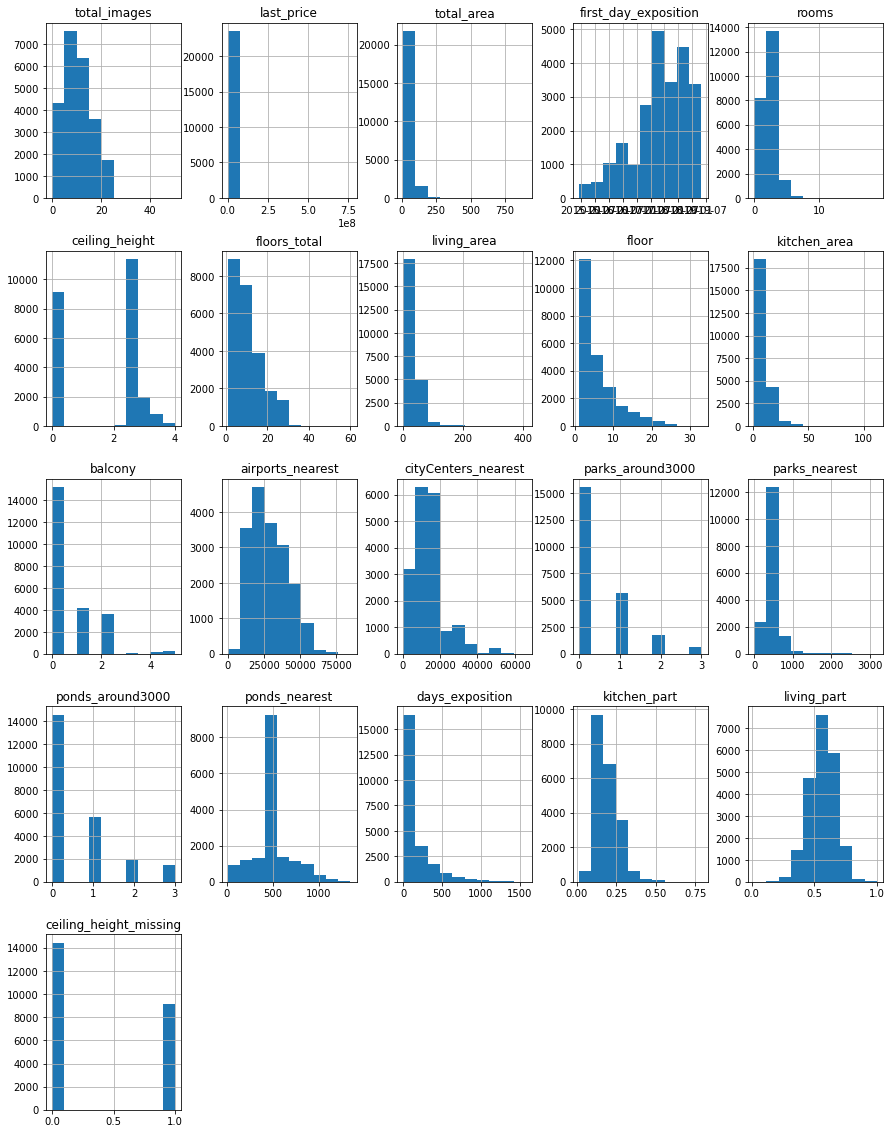

In [54]:
data.hist(figsize=(15, 20))
plt.show()

Некоторые столбцы хочется изучить на наличие аномалий несколько подробнее. Перечислим их. `last_price`, `total_area`, `living_area`, `kitchen_area`, `balcony`, `rooms`, `days_exposition`. Что касается столбцов, содержащих расстояния до каких-то объектов, то они выглядят прадоподобно: даже если там есть очень большие расстояния, это может значить, что эти квартиры находятся далеко от центра города, например; а если есть очень маленькие, тоже не критично: дом, в котором продается квартира, может находиться в центре города. Столбцы, в которых содержится информация о количестве водоемов и парков в радиусе 3 км, также выглядят правдоподобно. А столбец, в котором хранятся даты публикации объявлений, не представляет большого интереса с точки зрения аномалий.

###### last_price

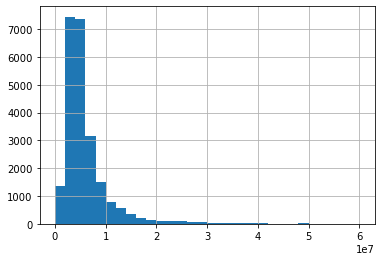

In [55]:
data['last_price'].hist(bins=30, range=(0, 0.6 * 10**8));

Видно, что большинство квартир стоят не больше 10 миллионов рублей. Однако встречаются и такие объекты, цена которых превышает 50 млн рублей. Скорее всего, это 4-комнатные квартиры. 3-комнатные квартиры тоже могут стоить довольно дорого (больше 20 млн рублей). Посмотрим на описательные статистики этой колонки

In [56]:
data['last_price'].describe()

count    2.359900e+04
mean     6.491448e+06
std      1.072059e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.626540e+06
75%      6.750000e+06
max      7.630000e+08
Name: last_price, dtype: float64

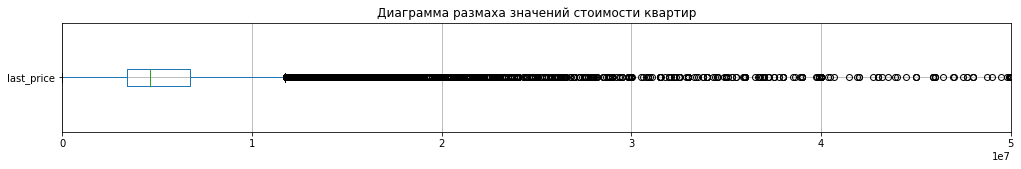

In [57]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['last_price']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений стоимости квартир')
ax.set_xlim(0, 50000000);

Посмотрим, сколько квартир продается по сильно высокой цене (более 30 млн рублей)

In [58]:
data.loc[data['last_price'] > 30 * 10**6, 'last_price'].shape[0]

301

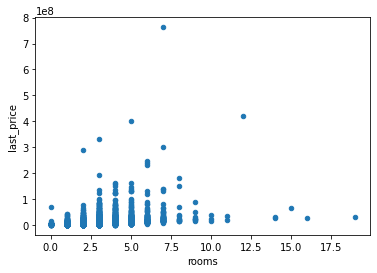

In [59]:
data.plot(x='rooms', y='last_price', kind='scatter');

Построенные графики и описательные статистики позволяют понять, что в данных есть довольно много объектов, цена которых выше 30 млн рублей. Скорее всего, это квартиры, в которых 3, 4 или больше комнат. Однако эти дорогостоящие квартиры вряд ли являются среднестатистическими, а потому в нашем исследовании их можно считать выбросами. Удалим все такие квартиры.

In [60]:
data = data.loc[data['last_price'] <= 30 * 10**6]

Теперь обратим внимание на нижнюю границу цен. Квартира стоит 10000 рублей... Это аномально низкая стоимость! Странно, чтобы квартиры стоили меньше миллиона. Посмотрим, сколько таких дешевых квартир.

In [61]:
# Количество квартир, стоимость которых меньше миллиона рублей
data.loc[data['last_price'] < 10**6, 'last_price'].shape[0]

224

In [62]:
data.loc[data['last_price'] < 10**6, 'last_price'].sort_values(ascending=False)

16792    999999.0
1753     999000.0
13362    995000.0
14281    990000.0
5801     990000.0
           ...   
5673     450000.0
16207    440000.0
14848    430000.0
17384    430000.0
8751      12190.0
Name: last_price, Length: 224, dtype: float64

Естественно предположить, что квартира, якобы стоившая 12000, на самом деле стоила в 100 раз дороже, то есть 1.2 млн рублей. Что касается остальных квартир, то они, скорее всего, должны бы стоить на порядок дороже, то есть несколько миллионов. Исправим эти аномалии.

In [63]:
data.loc[data['last_price'] < 10**6, 'last_price'] *= 10
data.loc[8751, 'last_price'] *= 10

In [64]:
# Проверка
data.loc[data['last_price'] < 10**6, 'last_price'].shape[0], data.loc[8751, 'last_price']

(0, 1219000.0)

###### rooms, balcony

Из [графика зависимости итоговой стоимости квартиры от количества комнат в ней](#price_rooms) можно извлечь информацию о том, что в данных есть такие квартиры, в которых больше 7 комнат. Однако в Санкт-Петербурге действительно продаются такие квартиры. Поэтому в этом столбце необычных значений нет. А раз у нас есть квартиры, в которых больше 10 комнат, то неудивительно, что есть квартиры с 4-5 балконами. Однако, чтобы можно было делать корректные ввыводы относительно основной массы квартир, необходимо, чтобы выдающихся значений было как можно меньше.

In [65]:
data['rooms'].describe()

count    23298.000000
mean         2.039445
std          1.029019
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         16.000000
Name: rooms, dtype: float64

In [66]:
data['balcony'].describe()

count    23298.000000
mean         0.592368
std          0.958326
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: balcony, dtype: float64

В большинстве квартир балконов нет. А что касается квартир с большим количеством комнат (большая часть из них была удалена при устранении аномалий по ценам), то таких не очень много, потому что еще 3 квартиль имеет значение 3...

In [67]:
data[data['rooms'] > 7].shape[0]

19

Квартир, в которых больше 4 комнат всего 19 на фоне 23 тысяч. Удалим эти строки, чтобы сохранить объективность в данных.

In [68]:
data = data[data['rooms'] <= 7]

Разберемся с квартирами, в которых 0 комнат. Если это квартиры с открытой планировкой или квартиры-студии, то заменим 0 на 1. А если это другие квартиры, то просто удалим их.

In [69]:
data[(data['rooms'] == 0) & (data['open_plan'] | data['studio'])].shape[0]

195

In [70]:
data[data['rooms'] == 0].shape[0]

195

In [71]:
list(data[(data['rooms'] == 0) & (data['open_plan'] | data['studio'])].index) == list(data[data['rooms'] == 0].index)

True

Видно, что все квартиры с нулевым количеством комнат - это либо квартиры с открытой планировкой, либо квартиры-студии

In [72]:
data.loc[(data['rooms'] == 0) & (data['open_plan'] | data['studio']), 'rooms'] = 1

###### total_area, living_area, kitchen_area

Посмотрим теперь на площади

In [73]:
data['total_area'].describe()

count    23279.000000
mean        58.063026
std         27.620468
min         12.000000
25%         40.000000
50%         51.400000
75%         68.100000
max        460.800000
Name: total_area, dtype: float64

Видно, что в основном площади квартир находятся в пределах 100 кв. м. Посмотрим на количество квартир с большей площадью

In [74]:
data.loc[data['total_area'] > 100, 'rooms'].value_counts()

3    585
4    499
5    231
2     75
6     73
7     38
1      6
Name: rooms, dtype: int64

В основном в этих квартирах от 3 до 7 комнат. А вот 1-комнатные и 2-комнатные квартиры площадью больше 100 кв. м больше смахивают на выброс. Посмотрим на гистограммы площадей

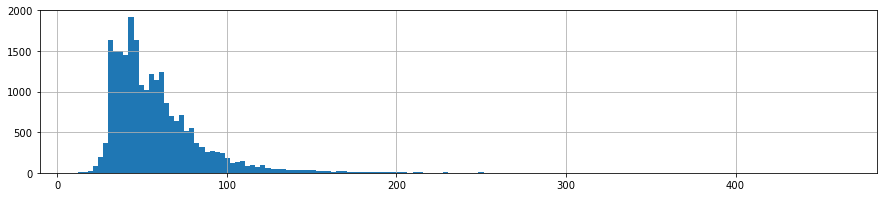

In [78]:
data['total_area'].hist(bins=150, figsize=(15,3));

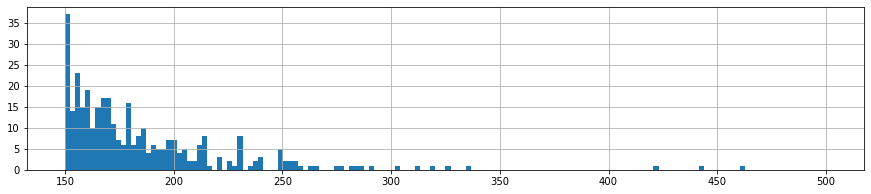

In [79]:
data['total_area'].hist(bins=150, figsize=(15,3), range=(150, 500));

Видно, что редкостями можно считать квартиры, площадь которых превышает 250 кв м и квартиры, в которых количество комнат меньше 3, а площадь больше 100 кв м. Посмотрим на их количество

In [80]:
data.loc[(data['total_area'] > 250) | ((data['rooms'] < 3) & (data['total_area'] > 100)), 'total_area'].count()

105

Удалим такие квартиры

In [81]:
data = data[data['total_area'] <= 250]
data = data[~((data['rooms'] < 3) & (data['total_area'] > 100))]

Теперь разберемся с жилплощадью

In [82]:
data['living_area'].describe()

count    23174.000000
mean        32.942878
std         17.300015
min          2.000000
25%         18.800000
50%         30.000000
75%         41.500000
max        177.000000
Name: living_area, dtype: float64

Что касается максимальной жилплощади, то тут ничего удивительного нет: у нас есть квартиры, в которых 3-7 комнат и общая площадь больше 100 кв м. А вот 2 кв м - это маловато. Удалим строки, в которых жилплощадь меньше 5 кв м.

In [83]:
data = data.loc[data['living_area'] > 5]

Посмотрим на площадь кухни.

In [84]:
data['kitchen_area'].describe()

count    23169.000000
mean        10.172021
std          4.914871
min          1.300000
25%          7.000000
50%          9.000000
75%         11.700000
max         70.000000
Name: kitchen_area, dtype: float64

Согласно нормативам, минимальная площадь кухни составляет 5 кв м. Поэтому квартиры с площадью кухни менее 5 кв м просто исключим из анализа.

In [85]:
data[data['kitchen_area'] < 5].shape[0]

202

Таких квартир тоже немного. Поэтому их можно удалять безболезненно.

In [86]:
data = data[data['kitchen_area'] >= 5]

In [87]:
# Проверка
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22967 entries, 0 to 23598
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            22967 non-null  int64         
 1   last_price              22967 non-null  float64       
 2   total_area              22967 non-null  float64       
 3   first_day_exposition    22967 non-null  datetime64[ns]
 4   rooms                   22967 non-null  int64         
 5   ceiling_height          22967 non-null  float64       
 6   floors_total            22967 non-null  int32         
 7   living_area             22967 non-null  float64       
 8   floor                   22967 non-null  int64         
 9   is_apartment            22967 non-null  bool          
 10  studio                  22967 non-null  bool          
 11  open_plan               22967 non-null  bool          
 12  kitchen_area            22967 non-null  float6

###### days_exposition

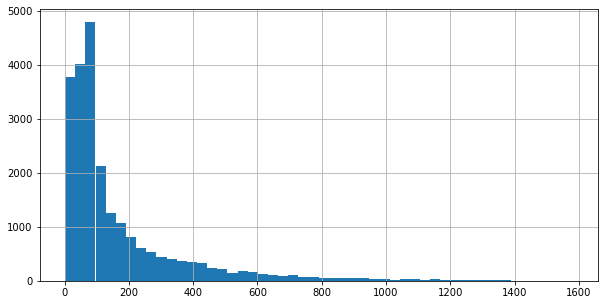

In [88]:
data['days_exposition'].hist(bins=50, figsize=(10, 5));

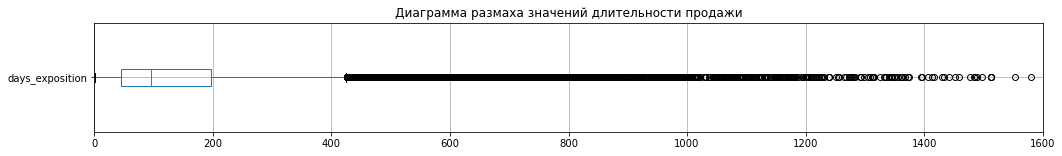

In [89]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['days_exposition']].boxplot(vert = False, ax=ax)
ax.set_title('Диаграмма размаха значений длительности продажи')
ax.set_xlim(0, 1600);

In [90]:
data['days_exposition'].describe()

count    22967.000000
mean       168.103279
std        204.772685
min          1.000000
25%         45.000000
50%         95.000000
75%        197.000000
max       1580.000000
Name: days_exposition, dtype: float64

Построенные графики и описательные статистики показывают, что в основном все квартиры продаются в течение 200 дней, то есть в течение примерно 7 месяцев. Однако в данных присутствуют и слишком долгие продажи (более 1000 дней) и слишком быстрые (меньше недели). Посмотрим на их количество.

In [91]:
print(f'Доля слишком быстрых продаж: {data[data["days_exposition"] <= 7].shape[0] / data.shape[0] : .1%}')
print(f'Доля слишком долгих продаж: {data[data["days_exposition"] > 1000].shape[0] / data.shape[0] : .1%}')

Доля слишком быстрых продаж:  3.6%
Доля слишком долгих продаж:  1.1%


Так как количество этих продаж не превышает 5% от общего числа наблюдений и эти продажи явно не являются обычным явлением, то просто исключим их из анализа.

In [92]:
data = data[(data["days_exposition"] > 7) & (data["days_exposition"] <= 1000)]

Проверим теперь, остались ли в каких-либо столбцах аномалии.

In [93]:
(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"21,882.00","21,882.00","21,882.00","21,882.00","21,882.00","21,882.00","21,882.00","21,882.00","21,882.00"
min,1.00,13.00,0.00,8.00,"1,000,000.00",5.40,5.00,1.00,1.00
max,7.00,250.00,4.00,"1,000.00","30,000,000.00",177.00,70.00,32.00,60.00


Заметим, что в столбце `floors_total` остались аномально большие для этого столбца значения: 60 этажей. Для современных домов это многовато. Да и если есть такие высокие дома, то их очень мало. Посмотрим на количество домов, в которых больше 30 этажей.

In [94]:
data[data['floors_total'] > 30].shape[0]

30

Их всего 30 штук. Удалим их.

In [95]:
data = data[data['floors_total'] <= 30]

Теперь все аномалии устранены. Можно переходить к следующему этапу подготовки данных для проведения анализа.

### Добавление столбцов для проведения анализа

Цена одного квадратного метра

In [96]:
data['square_cost'] = data['last_price'] / data['total_area']

Время публикации объявления: день недели, месяц, год

In [97]:
data['start_exposition_weekday'] = data['first_day_exposition'].dt.weekday
data['start_exposition_month'] = data['first_day_exposition'].apply(lambda x: x.month)
data['start_exposition_year'] = data['first_day_exposition'].apply(lambda x: x.year)

Тип этажа квартиры: первый, последний, другой. Предварительно проверим, что в наших данных нет квартир на 0 или отрицательном этаже

In [98]:
data[data['floor'] < 1].shape[0]

0

In [99]:
def categorize_floors(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'


data['floors_type'] = data.apply(categorize_floors, axis=1)

Расстояние до центра города в км

In [100]:
# Для начала исправим название столбца с расстоянием до центра города
data = data.rename(columns={'cityCenters_nearest' : 'city_centers_nearest'})

In [101]:
def city_centers_processing(x):
    try:
        return round(x / 1000)
    except:
        pass


data['city_centers_nearest_km'] = data['city_centers_nearest'].apply(city_centers_processing)

In [102]:
# Проверка
data['city_centers_nearest_km'].head()

0    16.0
1    19.0
2    14.0
4     8.0
5     NaN
Name: city_centers_nearest_km, dtype: float64

### Исследовательский анализ

#### Анализ некоторых параметров

###### Общая площадь

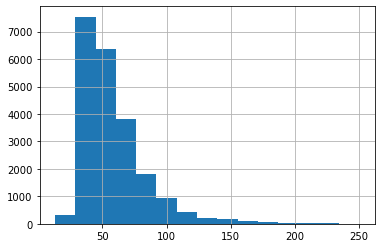

In [103]:
data['total_area'].hist(bins=15);

In [104]:
data['total_area'].describe()

count    21852.000000
mean        57.953517
std         26.286720
min         13.000000
25%         40.000000
50%         52.000000
75%         68.000000
max        250.000000
Name: total_area, dtype: float64

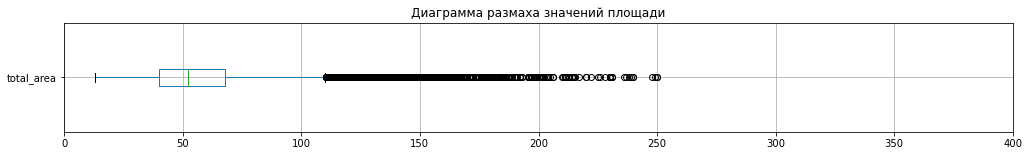

In [105]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['total_area']].boxplot(vert=False, ax=ax)
ax.set_title('Диаграмма размаха значений площади')
ax.set_xlim(0, 400);

Из графиков и описательных статистики по этой колонке видно, что в основном площадь не превышает 100 кв м. Медианное значение общей площади (52 кв м) показывает площадь среднестатистической квартиры (правда, хорошо бы смотреть на площадь квартиры в зависимости от количества комнат в ней). Минимальная площадь - 13 кв м, это соответствует нормативам. Также есть довольно много квартир, площадь которых превышает 100 кв м. С большой вероятностью это квартиры, в которых более 3 комнат. Посмотрим на площадь квартиры в зависимости от количества комнат в ней.

In [106]:
rooms_total_area_pivot = data.pivot_table(index='rooms', values='total_area', aggfunc=['count', 'min', 'median', 'max'])
rooms_total_area_pivot.columns = rooms_total_area_pivot.columns.droplevel(1)
rooms_total_area_pivot

,count,min,median,max
rooms,,,,
1,7636,13.0,36.56,98.4
2,7389,20.0,53.00,100.0
3,5427,40.1,72.20,250.0
4,1052,42.0,96.95,240.0
5,245,40.0,130.00,250.0
6,69,87.0,165.00,237.0
7,34,100.6,193.50,249.0


Из сводной таблицы видно, что больше всего 2-комнатных и 1-комнатных квартир; 3-комнатных тоже довольно много, а вот 4-комнатных и всех остальных уже существенно меньше. Причем по количеству квартир в группе они распределились так, что медианное значение для 2-комнатных квартир близко к общему медианному значению. Выводы мы можем делать только по квартирам, в которых меньше 5 комнат. Общие тенденции: с увеличением количества комнат площадь растет.

###### Жилплощадь

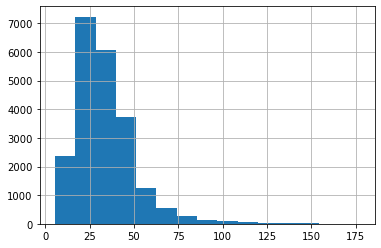

In [107]:
data['living_area'].hist(bins=15);

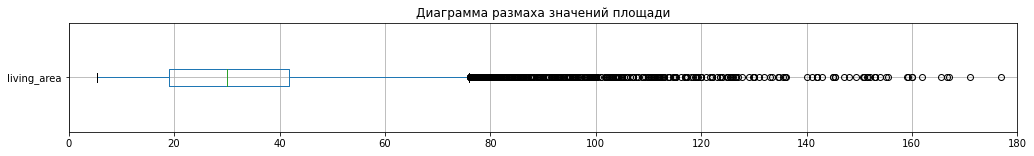

In [108]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['living_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений площади')
ax.set_xlim(0, 180);

In [109]:
data['living_area'].describe()

count    21852.000000
mean        33.138587
std         17.366578
min          5.400000
25%         19.000000
50%         30.000000
75%         41.800000
max        177.000000
Name: living_area, dtype: float64

В большинстве квартир жилплощадь лежит в диапазоне от 19 до 42 кв м. Однако в данных имеются квартиры с 5 и более комнатами, а также большие квартиры с меньшим количеством комнат, соответственно, в них площадь запросто может лежать за пределами доверительного интервала. минимальная жилплощадь - 5.4 кв м, это вполне правдоподобно (например, какая-нибудь коммунальная квартира). Как и в случае общей площади, посмотрим на статистику по квартирам с разным количеством комнат

In [110]:
rooms_living_area_pivot = data.pivot_table(index='rooms', values='living_area', aggfunc=['count', 'min', 'median', 'max'])
rooms_living_area_pivot.columns = rooms_living_area_pivot.columns.droplevel(1)
rooms_living_area_pivot['min'] = np.round(rooms_living_area_pivot['min'], 2)
rooms_living_area_pivot['max'] = np.round(rooms_living_area_pivot['max'], 2)
rooms_living_area_pivot

,count,min,median,max
rooms,,,,
1,7636,6.00,17.80,60.50
2,7389,8.00,30.40,64.00
3,5427,12.50,44.50,134.56
4,1052,5.40,62.00,153.00
5,245,23.60,86.00,159.00
6,69,51.00,110.30,171.00
7,34,56.82,127.05,177.00


Здесь мы снова видим вполне естественную закономерность: с увеличением количества комнат растет медианное значение жилплощади. Однако если посмотреть на минимальную жилплощадь, то можно уведеть довольно странные вещи: минимальная жилплощадь в 4-комнатной квартире составляет 5.4 кв м. Даже в 1-комнатных больше... Что-то тут не так. Посмотрим на 4-комнатные квартиры отдельно.

In [111]:
data.loc[data['rooms'] == 4, ['total_area', 'living_area', 'kitchen_area']].sort_values(by='living_area')

,total_area,living_area,kitchen_area
21850,77.6,5.400000,9.800000
13680,80.0,23.000000,14.000000
20021,42.0,23.720152,7.869763
12978,42.0,23.720152,7.869763
9919,49.5,27.955893,9.275078
...,...,...,...
18638,240.0,135.543725,15.000000
4954,228.0,141.000000,40.400000
7875,204.0,148.000000,34.000000
21586,181.3,153.000000,9.000000


Такая странная 4-комнатная квартира только одна. Возможно, когда заполнялась анкета, вместо 54 кв м (а это более вероятное значение жилплощади в данном случае) написали 5.4. Исправим это

In [112]:
data.loc[21850, 'living_area'] *= 10

Обновим сводную таблицу

In [113]:
rooms_living_area_pivot = data.pivot_table(index='rooms', values='living_area', aggfunc=['count', 'min', 'median', 'max'])
rooms_living_area_pivot.columns = rooms_living_area_pivot.columns.droplevel(1)
rooms_living_area_pivot['min'] = np.round(rooms_living_area_pivot['min'], 2)
rooms_living_area_pivot['max'] = np.round(rooms_living_area_pivot['max'], 2)
rooms_living_area_pivot

,count,min,median,max
rooms,,,,
1,7636,6.00,17.80,60.50
2,7389,8.00,30.40,64.00
3,5427,12.50,44.50,134.56
4,1052,23.00,62.00,153.00
5,245,23.60,86.00,159.00
6,69,51.00,110.30,171.00
7,34,56.82,127.05,177.00


Теперь все встало на свои места.

###### Площадь кухни

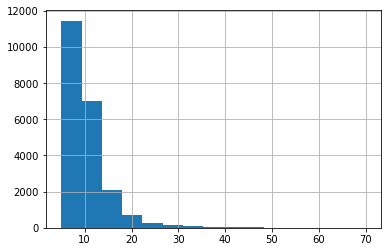

In [114]:
data['kitchen_area'].hist(bins=15);

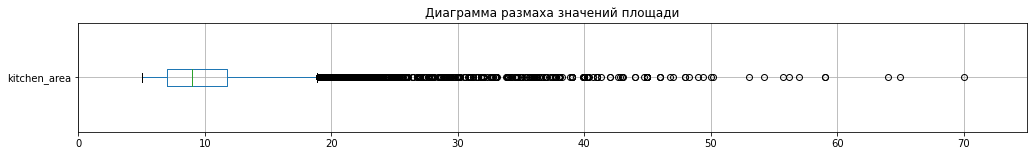

In [115]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['kitchen_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений площади')
ax.set_xlim(0, 75);

In [116]:
data['kitchen_area'].describe()

count    21852.000000
mean        10.223469
std          4.885112
min          5.000000
25%          7.000000
50%          9.000000
75%         11.780000
max         70.000000
Name: kitchen_area, dtype: float64

В основном площадь кухни лежит в пределах 7-11 кв м, минимальная площадь - 5 кв м, а вот максимальная - около 70 кв м. 

In [117]:
rooms_kitchen_area_pivot = data.pivot_table(index='rooms', values='kitchen_area', aggfunc=['count', 'min', 'median', 'max'])
rooms_kitchen_area_pivot.columns = rooms_kitchen_area_pivot.columns.droplevel(1)
rooms_kitchen_area_pivot

,count,min,median,max
rooms,,,,
1,7636,5.0,9.00,49.0
2,7389,5.0,9.00,48.3
3,5427,5.0,10.00,65.0
4,1052,5.0,11.25,70.0
5,245,5.0,14.90,59.0
6,69,5.9,17.00,42.0
7,34,5.0,17.00,46.0


Здесь также, как и в случае с общей площадью и жилплощадью, медианное значение растет с ростом количества комнат

###### Цена объекта

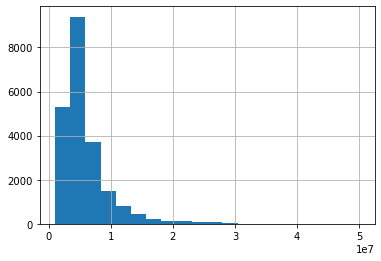

In [118]:
data['last_price'].hist(bins=20, range=(1000000, 50000000));

На гистограмме наблюдается пик в районе 5 млн рублей. Большинство квартир стоят от 1 до 11 млн рублей. Зависимости цены объекта от разных параметров будут изучены позже.

###### Этаж квартиры и тип этажа квартиры

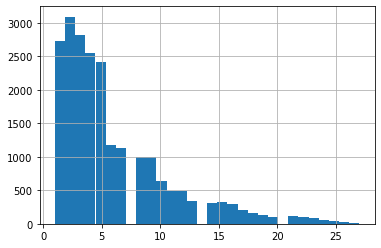

In [119]:
data['floor'].hist(bins=30);

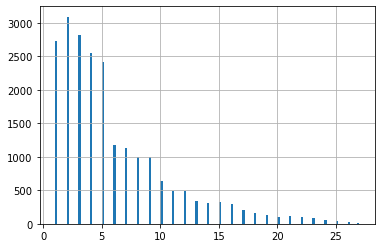

In [120]:
data['floor'].hist(bins=130);

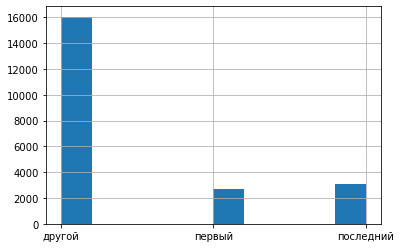

In [121]:
data['floors_type'].hist();

Большинство квартир находятся не выше 10 этажа. Также есть квартиры, которые находятся выше 20 этажа, но таких крайне мало по сравнению с остальными: настолько высоких зданий не так много, да и жить так высоко не каждый сможет и захочет (например, пожилым людям это будет тяжело). Также стоит отметить, что, начиная с 6 этажа, наблюдается резкое падение количества объявлений о продаже квартиры.

Теперь о типах этажа. Как видно, меньше всего квартир на первом этаже, на последнем тоже сравнительно немного, а вот этажей типа "другой" полным-полно. Про ситуацию с последними этажами я уже немного написал. Добавлю только, что последний этаж иногда доставляет какой-то психологический дискомфорт, но главное - семьям с детьми и пожилым людям жить довольно высоко не очень удобно, поэтому там, скорее всего, молодые люди, студенты, у которых еще нет семьи, например. А на первых этажах жилых домов часто располагаются какие-нибудь небольшие магазины, парикмахерские, аптеки и другие заведения, поэтому там тоже немного жильцов.

###### Общее количество этажей в доме

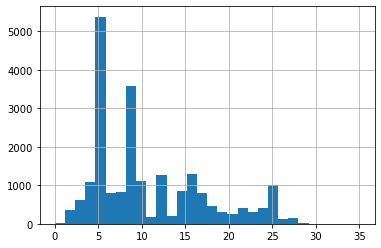

In [122]:
data['floors_total'].hist(bins=30, range=(0, 35));

Больше всего 5-этажных зданий. Также есть пик в районе 9 этажей. Домов с другим количеством этажей меньше.

###### Количество комнат

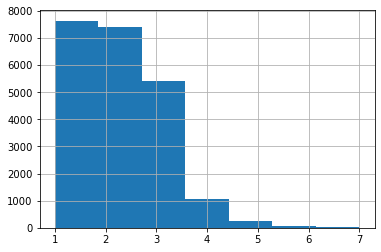

In [123]:
data['rooms'].hist(bins=7);

Эта гистограмма наглядно показывает, что в большинстве квартир 1-3 комнаты, причем больше всего 1-комнатных квартир. А квартир, в которых комнат больше 4, крайне мало.

###### Высота потолков

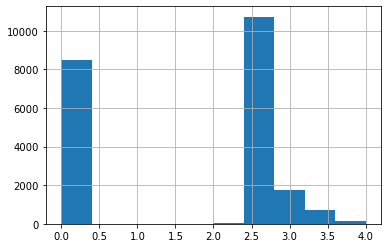

In [124]:
data['ceiling_height'].hist();

В большинстве квартир высота потолков варьируется от 2.25 до 3.25 м. Пик приходится на 2.5-2.75 м.

###### Расстояние до центра города в метрах

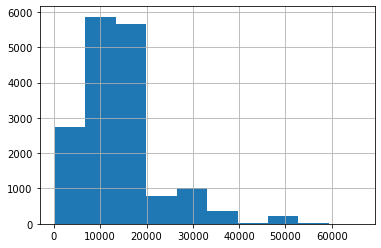

In [125]:
data['city_centers_nearest'].hist();

Как видно, большинство объектов находятся в радиусе 20 км от центра города. Скорее всего, это объекты из Санкт-Петербурга. Также следует отметить, что в радиусе 50 км наблюдается некоторое повышение численности продававшихся квартир по сравнению с численностью квартир в радиусах 40, 60 и больше км.

###### Расстояние до ближайшего аэропорта

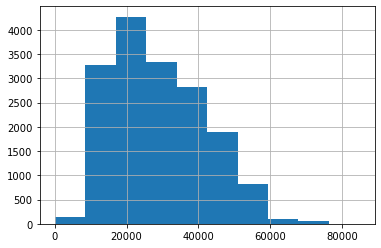

In [126]:
data['airports_nearest'].hist();

Довольно интересная гистограмма. Мы видим, что есть некоторое количество объектов в непосредственной близости от аэропорта, основной пик приходится на расстояние в 20 км. Затем наблюдается довольно плавный спад количества квартир. Менее всего квартир в радиусе 60 и больше км от аэропортов. Важно понимать, что есть определенное количество объектов, для которых это расстояние не указано. С большой вероятностью можно утверждать, что это объекты из сельской местности Ленинградской области.

###### Расстояние до ближайшего парка

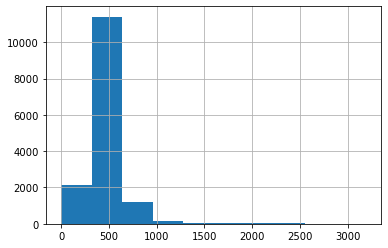

In [127]:
data['parks_nearest'].hist();

Скорее всего, в статистику попали только объекты из городов, причем преимущественно из Санкт-Петербурга. Среди квартир, которые попали в статистику, подавляющее большинство находятся недалеко от парков: расстояние обычно не превышает 1 км, то есть не более 10 минут пешком. Пик приходится на 500 м.

###### День и месяц публикации объявления

*под днем будем понимать день недели

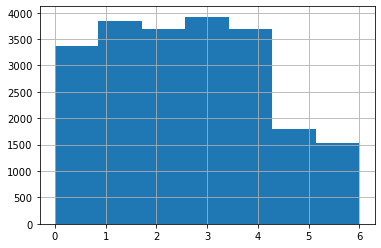

In [128]:
data['start_exposition_weekday'].hist(bins=7);

Гистограмма показывает, что публикация в разные дни недели по будням происходит почти равновероятно, на выходных публикуют раза в 2 меньше. Особой популярностью пользуются вторник и четверг.

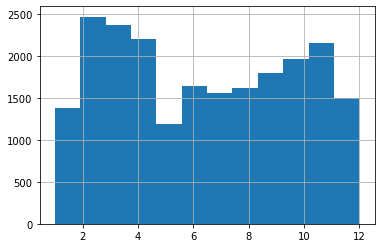

In [129]:
data['start_exposition_month'].hist(bins=12);

Что касается зависимости публикации объявлений от месяца, то тут картина тоже довольно интересная. В декабре и в январе публикаций мало. Скорее всего, это связано с тем, что мало кому хочется переезжать зимой, да еще и под Новый Год. Чаще всего публикации объявлений о продаже квартиры появляются в феврале-апреле. Потом наблюдается резкий спад (почти в два раза), а к ноябрю уровень постепенно восстанавливается.

#### Изучение скорости продаж квартир

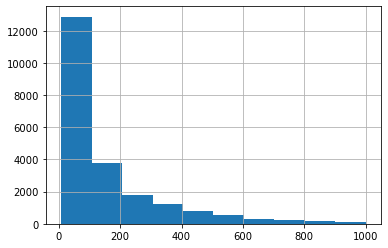

In [130]:
data['days_exposition'].hist();

In [131]:
data['days_exposition'].describe()

count    21852.000000
mean       162.447282
std        176.052584
min          8.000000
25%         52.000000
50%         95.000000
75%        197.000000
max       1000.000000
Name: days_exposition, dtype: float64

Из гистограммы и описательных статистик видно, что большинство квартир продается в течение 7 месяцев с момента публикации объявления - это примерно 75-й процентиль. Медианное значение существенно отличается от среднего, это связано прежде всего с тем, что в данных присутствуют как сильно маленькие значения (скажем, меньше месяца), так и сильно большие (несколько лет). Медианное значение довольно хорошо характеризует выборку в целом. То есть среднестатистическая продажа совершается где-то за 100 дней - это чуть больше 3 месяцев. Продажи, которые совершились за срок, меньший 52 дней (25-й процентиль), будем считать быстрыми; а те, которые произошли за 197 дней (75-й процентиль) и больше, - долгими.

Посмотрим на изменение средней скорости продаж по годам.

In [132]:
sales_speed_year_pivot = data.pivot_table(index='start_exposition_year', values='days_exposition', aggfunc='mean')
sales_speed_year_pivot['days_exposition'] = np.round(sales_speed_year_pivot['days_exposition'], 2)
sales_speed_year_pivot

,days_exposition
start_exposition_year,
2014,589.50
2015,508.99
2016,309.10
2017,161.67
2018,98.85
2019,74.83


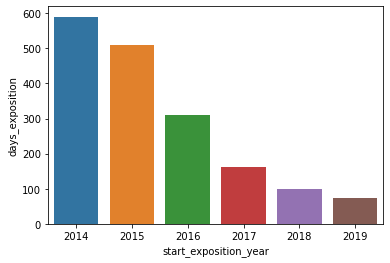

In [133]:
sns.barplot(x=sales_speed_year_pivot.index, y=sales_speed_year_pivot['days_exposition']);

Видно, что, начиная с 2014 года, средняя скорость плавно росла, и в 2019 году она достигла своего максимума (разумеется, на исследуемом временном интервале) - всего 75 дней (2.5 месяца).

##### Вывод

Большинство квартир продаются за 7 месяцев с момента публикации объявления. Медианное значение - чуть больше 3 месяцев (100 дней). Однако в данных присутствуют и другие значения: быстрые продажи (меньше 52 дней) и долгие продажи (больше 197 дней). Также стоит отметить, что, начиная с 2014 года, средняя скорость продаж плавно росла, и в 2019 году она достигла своего максимума в 2.5 месяца.

#### Влияние различных факторов на полную стоимость объекта

###### Общая площадь

In [134]:
total_last_price_pivot = data.pivot_table(index='total_area', values='last_price', aggfunc='median')
total_last_price_pivot.head()

,last_price
total_area,
13.00,3800000.0
15.50,2450000.0
17.00,1500000.0
17.60,3400000.0
17.78,1737000.0


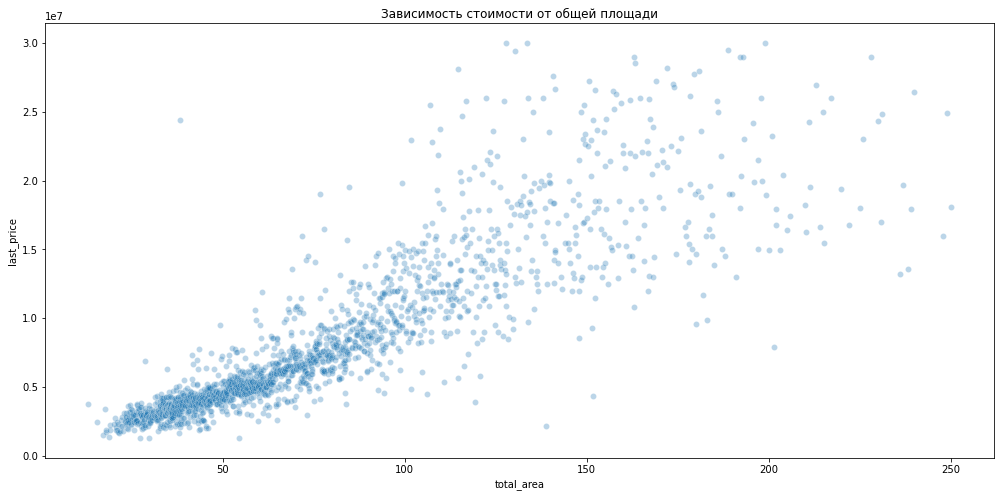

In [135]:
fig, ax = plt.subplots(figsize = (17, 8))
ax = sns.scatterplot(x=total_last_price_pivot.index, y=total_last_price_pivot['last_price'], alpha=0.3, ax=ax)
ax.set_title('Зависимость стоимости от общей площади');

###### Жилплощадь

In [136]:
living_last_price_pivot = data.pivot_table(index='living_area', values='last_price', aggfunc='median')
living_last_price_pivot.head()

,last_price
living_area,
6.0,3799500.0
6.5,4050000.0
8.0,4100000.0
8.3,4000000.0
8.4,4200000.0


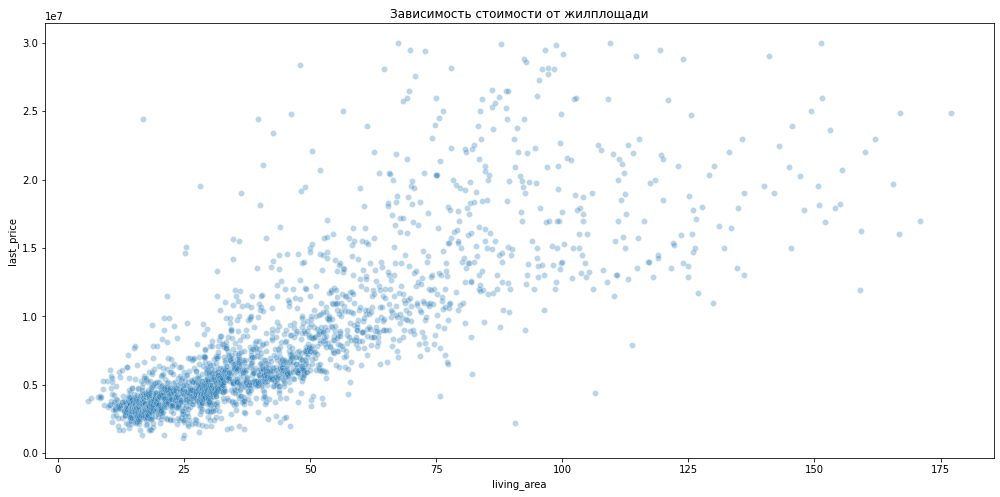

In [137]:
fig, ax = plt.subplots(figsize = (17, 8))
ax = sns.scatterplot(x=living_last_price_pivot.index, y=living_last_price_pivot['last_price'], alpha=0.3, ax=ax)
ax.set_title('Зависимость стоимости от жилплощади');

###### Площадь кухни

In [138]:
kitchen_last_price_pivot = data.pivot_table(index='kitchen_area', values='last_price', aggfunc='median')
kitchen_last_price_pivot.head()

,last_price
kitchen_area,
5.000000,3050000.0
5.002921,2700000.0
5.040396,3400000.0
5.059133,2922500.0
5.060000,3400000.0


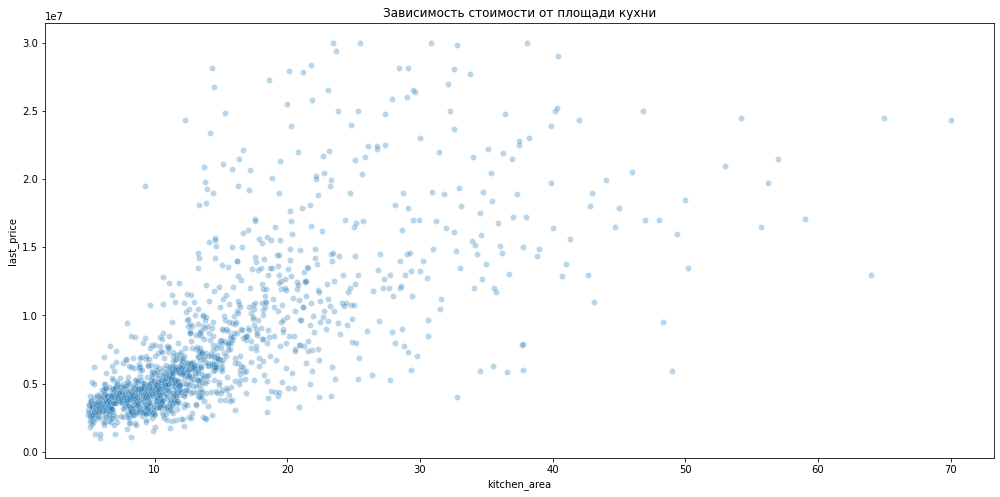

In [139]:
fig, ax = plt.subplots(figsize = (17, 8))
ax = sns.scatterplot(x=kitchen_last_price_pivot.index, y=kitchen_last_price_pivot['last_price'], alpha=0.3, ax=ax)
ax.set_title('Зависимость стоимости от площади кухни');

Эта три графика наглядно показывают зависимость стоимости квартиры от площади. В целом видно, что с ростом площади цена растет, что вполне логично. Однако, чем больше площадь, тем сильнее ценовой разброс, причем это касается и общей площади, и жилплощади, и площади кухни.

###### Количество комнат

In [140]:
rooms_last_price_pivot = data.pivot_table(index='rooms', values='last_price', aggfunc='median')
rooms_last_price_pivot

,last_price
rooms,
1,3600000.0
2,4800000.0
3,6190000.0
4,8725000.0
5,12450000.0
6,14700000.0
7,17650000.0


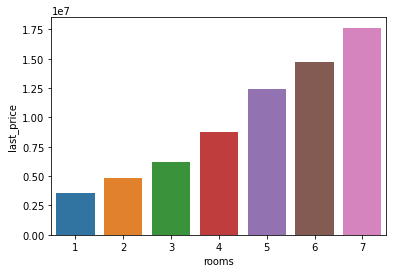

In [141]:
sns.barplot(x=rooms_last_price_pivot.index, y=rooms_last_price_pivot['last_price']);

Видно, что количество комнат сильно влияет на стоимость квартиры: с ростом количества комнат цена сильно повышается; зависимость уже не линейная, а полинимиальная. Это логично, потому что чем больше комнат, тем больше квартира, соответственно, тем она и дороже.

###### Тип этажа

In [142]:
floor_type_last_price_pivot = data.pivot_table(index='floors_type', values='last_price', aggfunc='median')
floor_type_last_price_pivot

,last_price
floors_type,
другой,4800000.0
первый,4000000.0
последний,4400000.0


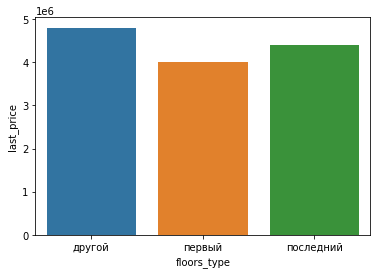

In [143]:
sns.barplot(x=floor_type_last_price_pivot.index, y=floor_type_last_price_pivot['last_price']);

Среднестатистические квартиры на первом этаже стоят дешевле среднестатистических квартир на более высоких этажах. Также и квартиры на последних этажах обычно дешевле квартир на более низких (кроме первых) этажах.

###### Даты публикации объявления (день недели, месяц, год)

*День недели*

In [144]:
start_weekday_price = data.pivot_table(index='start_exposition_weekday', values='last_price', aggfunc='median')
start_weekday_price

,last_price
start_exposition_weekday,
0,4650000.0
1,4750000.0
2,4790000.0
3,4650000.0
4,4600000.0
5,4600000.0
6,4550000.0


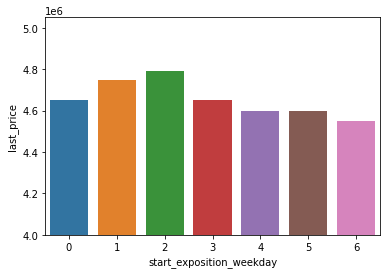

In [145]:
fig, ax = plt.subplots()

sns.barplot(x=start_weekday_price.index, y=start_weekday_price['last_price'], ax=ax)
ax.set_ylim(4000000, 5050000)
plt.show()

Видно, что в основном цены одинаковые, но во вторник и в среду есть некоторое повышение.

*Месяц*

In [146]:
start_month_price = data.pivot_table(index='start_exposition_month', values='last_price', aggfunc='median')
start_month_price

,last_price
start_exposition_month,
1,4600000.0
2,4680000.0
3,4700000.0
4,4800000.0
5,4570000.0
6,4490000.0
7,4650000.0
8,4600000.0
9,4699500.0


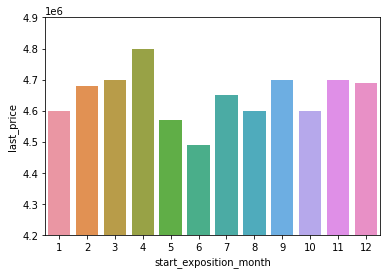

In [147]:
fig, ax = plt.subplots()

sns.barplot(x=start_month_price.index, y=start_month_price['last_price'], ax=ax)
ax.set_ylim(4200000, 4900000)
plt.show()

Из гистограммы видно, что в основном цены примерно одинаковые. Провалы наблюдаются в июне (самые низкие цены), в октябре и в августе. Провалы в июне, наверное, можно объяснить тем, что летом много кто живет на дачах, многие также уезжают куда-то на время отпуска и так далее.

*Год*

In [148]:
start_year_price = data.pivot_table(index='start_exposition_year', values='last_price', aggfunc='median')
start_year_price

,last_price
start_exposition_year,
2014,7388280.0
2015,5100000.0
2016,4550000.0
2017,4500000.0
2018,4600000.0
2019,5100000.0


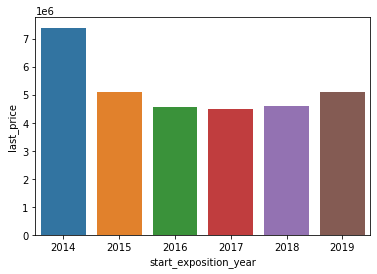

In [149]:
sns.barplot(x=start_year_price.index, y=start_year_price['last_price']);

В 2014 году были самые высокие цены на квартиры, затем цены плавно падали до 2017 года, после чего снова начался рост цен. Это падение отчасти обусловлено тогдашним кризисом и тяжелым положением рынка недвижимости в стране.

Чтобы сделать корректные выводы об изменении цен по годам, посмотрим на то, как менялось с годами количество объявлений о продаже.

In [150]:
start_year_count = data.pivot_table(index='start_exposition_year', values='last_price', aggfunc='count')
start_year_count = start_year_count.rename(columns={'last_price': 'count'})
start_year_count

,count
start_exposition_year,
2014,84
2015,924
2016,2617
2017,7685
2018,7901
2019,2641


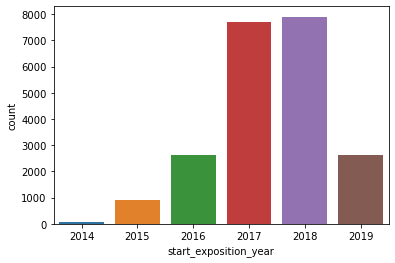

In [151]:
sns.barplot(x=start_year_count.index, y=start_year_count['count']);

Видно, что больше всего объявлений о продаже было в 2017-2018 годах. В эти годы цены на недвижимость очень сильно упали... Возможно, именно это способствовало увеличению количества желающих продать недвижимость, пока она не подешевела еще сильнее... А может, здесь есть еще какие-то нюансы. Посмотрим, как менялась с годами средняя площадь выставлявшихся на продажу квартир.

In [152]:
start_year_area = data.pivot_table(index='start_exposition_year', values='total_area', aggfunc='mean')
start_year_area['total_area'] = np.round(start_year_area['total_area'], 2)
start_year_area

,total_area
start_exposition_year,
2014,82.10
2015,64.70
2016,59.34
2017,58.17
2018,56.49
2019,57.19


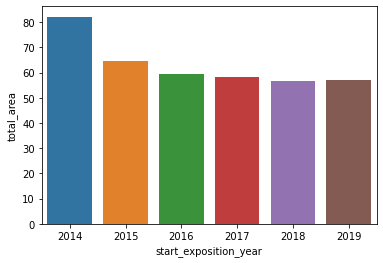

In [153]:
sns.barplot(x=start_year_area.index, y=start_year_area['total_area']);

С течением времени, площадь продававшихся квартир уменьшалась... Наверное, это связано с тем, что в тогдашних новостройках квартиры стали делать меньше.

Если подвести итог, то можно сказать следующее. 
* В 2014 году были самые высокие цены на квартиры, затем они плавно падали до 2017 года, после чего снова начался рост. Это падение отчасти обусловлено тогдашним кризисом и тяжелым положением рынка недвижимости в стране.

* Больше всего объявлений о продаже было в 2017-2018 годах. В эти годы цены на недвижимость очень сильно упали. Возможно, именно это способствовало увеличению количества желающих продать недвижимость, пока она не подешевела еще сильнее.

* С течением времени, площадь продававшихся квартир уменьшалась. Это может быть связано с тем, что в тогдашних новостройках квартиры стали делать меньше.

###### Тип местности

In [154]:
locality_type_last_price_pivot = data.pivot_table(index='locality_category', values='last_price', aggfunc='median')
locality_type_last_price_pivot

,last_price
locality_category,
СНТ,2175000.0
город,5000000.0
сельская местность,3250000.0


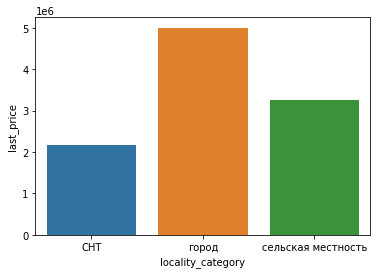

In [155]:
sns.barplot(x=locality_type_last_price_pivot.index, y=locality_type_last_price_pivot['last_price']);

Естественно, что в городах квартиры стоят дороже, чем в сельской местности. Разделим теперь города на две категории: Санкт-Петербург и другие города.

In [156]:
data['locality_category_new'] = data['locality_category'].copy()
data.loc[data['locality_name'] == 'санкт-петербург', 'locality_category_new'] = 'Санкт-Петербург'

In [157]:
locality_type_last_price_pivot = data.pivot_table(index='locality_category_new', values='last_price', aggfunc='median')
locality_type_last_price_pivot

,last_price
locality_category_new,
СНТ,2175000.0
город,5000000.0
сельская местность,3250000.0


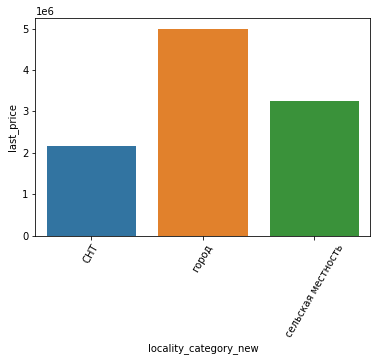

In [158]:
graph = sns.barplot(x=locality_type_last_price_pivot.index, y=locality_type_last_price_pivot['last_price'])
graph.set_xticklabels(graph.get_xticklabels(), rotation = 60)
plt.show()

Мы видим, что в Петербурге квартиры стоят дороже всего, что логично. На втором месте другие города области и сельская местность: количество продававшихся там квартир в сумме примерно одинаково. И последнее место занимают СНТ, что тоже соответствует логике.

##### Вывод

* С увеличением общей площади квартиры ее стоимость растет. Это также верно и для жилплощади, и для площади кухни. Однако, с ростом площади, ценовой разброс становится сильнее, причем это касается всех типов площадей, а сильнее всего этот факт проявляется на графике зависимости цены от площади кухни.

* С увеличением количества комнат стоимость квартиры растет полиномиально

* Квартиры на первом этаже стоят дешевле квартир на более высоких этажах. При этом квартиры на последних этажах обычно дешевле квартир на более низких (кроме первых) этажах

* Самые высокие цены на квартиры выставляются в начале недели (пик приходится на вторник); в выходные эта планка снижается примерно в 2 раза

* В основном по месяцам цены одинаковые. Провалы наблюдаются в июне (самые низкие цены), в октябре и в августе. Провалы в июне, вероятно, связаны с тем, что в это время низкий спрос на недвижимость.

* В 2014 году были самые высокие цены на квартиры, затем они плавно падали до 2017 года, после чего снова начался рост. Это падение отчасти обусловлено тогдашним кризисом и тяжелым положением рынка недвижимости в стране.

* Больше всего объявлений о продаже было в 2017-2018 годах. В эти годы цены на недвижимость очень сильно упали. Возможно, именно это способствовало увеличению количества желающих продать недвижимость, пока она не подешевела еще сильнее.

* С течением времени, площадь продававшихся квартир уменьшалась. Это может быть связано с тем, что в тогдашних новостройках квартиры стали делать меньше.

* В Петербурге самые дорогие квартиры в Ленинградской области. Второе место занимают остальные города и населенные пункты в сельской местности, последними идут СНТ

#### Средняя цена квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

Сгруппируем данные по населенным пунктам и выберем среди них 10 самых популярных по количеству объявлений. Также посчитаем среднюю цену квадратного метра.

In [159]:
data['square_price'] = data['last_price'] / data['total_area']

locality_pivot = data.pivot_table(index='locality_name', values='square_price', aggfunc=['count', 'mean'])
locality_pivot.columns = locality_pivot.columns.droplevel(1)
locality_pivot['mean'] = np.round(locality_pivot['mean'], 2)
locality_pivot = locality_pivot.sort_values(by='count', ascending=False).iloc[:10]
locality_pivot

,count,mean
locality_name,,
Санкт-Петербург,14381,110379.33
поселок Мурино,503,85437.27
поселок Шушары,420,78377.57
Всеволожск,382,68879.68
Пушкин,335,102078.11
Колпино,318,75078.13
поселок Парголово,309,89686.84
Гатчина,288,69172.54
деревня Кудрово,271,92071.77


Теперь выделим населенные пункты с минимальной и максимальной средней стоимостью квадратного метра.

In [160]:
print(f'Населенный пункт с максимальной стоимостью квадратного метра: {locality_pivot["mean"].idxmax()}')
print(f'Населенный пункт с минимальной стоимостью квадратного метра: {locality_pivot["mean"].idxmin()}')

Населенный пункт с максимальной стоимостью квадратного метра: Санкт-Петербург
Населенный пункт с минимальной стоимостью квадратного метра: Выборг


Построим диаграммы, которые отразят распределение количества объявлений и средней стоимости квадратного метра

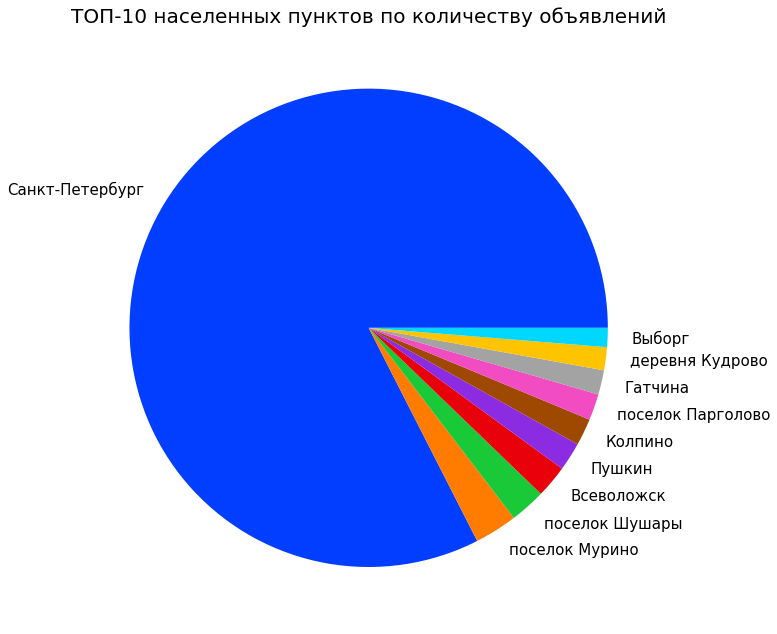

In [161]:
fig, ax = plt.subplots(figsize = (11, 11))

plt.pie(
    locality_pivot['count'],
    labels=locality_pivot.index,
    colors=sns.color_palette('bright'),
    textprops={'fontsize': 15}
)

plt.title('ТОП-10 населенных пунктов по количеству объявлений', fontsize=20)
plt.show()

In [162]:
locality_pivot = locality_pivot.sort_values(by='mean', ascending=False)
locality_pivot

,count,mean
locality_name,,
Санкт-Петербург,14381,110379.33
Пушкин,335,102078.11
деревня Кудрово,271,92071.77
поселок Парголово,309,89686.84
поселок Мурино,503,85437.27
поселок Шушары,420,78377.57
Колпино,318,75078.13
Гатчина,288,69172.54
Всеволожск,382,68879.68


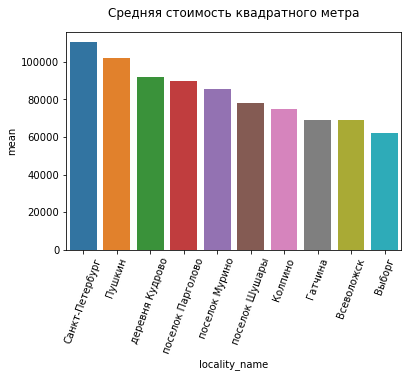

In [163]:
graph = sns.barplot(x=locality_pivot.index, y=locality_pivot['mean'])
graph.set_xticklabels(graph.get_xticklabels(), rotation = 70)
graph.set_title('Средняя стоимость квадратного метра', pad=15)

plt.show()

##### Вывод

Выбраны 10 населенных пунктов с самым большим числом публикаций объявлений о продаже квартир. Среди них лидирует Санкт-Петербург. Что касается средней стоимости квадратного метра. Среди этих населенных пунктов самый "дорогой" - Петербург, а самый "дешевый" - Выборг.

#### Средняя цена километра

Рассчитаем среднюю стоимость каждого километра от центра города

In [164]:
data['km_price'] = data['last_price'] / data['city_centers_nearest_km']
data.loc[data['km_price'] == np.inf, 'km_price'] = 0
mean_km_price = data.loc[data['locality_name'] == 'санкт-петербург', 'km_price'].mean()
round(mean_km_price)

ValueError: cannot convert float NaN to integer

Чтобы посмотреть на зависимость стоимости объекта от расстояния до центра города, сделаем следующее: возьмем срез данных - квартиры в Санкт-Петербурге - разобьем эти данные на группы по расстоянию (1 км и меньше, от 1 до 2 км и так далее) и по каждой группе посчитаем среднее. После этого построим график

In [165]:
# Функция для "округления"
def km_round(x):
    try:
        if abs(x - int(x)) > 0:
            return int(x) + 1
        return x
    except ValueError:
        return
        

# Отбор объектов из Петербурга
saint_petersburg_data = data[data['locality_name'] == 'санкт-петербург']
# Собственно округление
saint_petersburg_data['city_center_km_rounded'] = saint_petersburg_data['city_centers_nearest_km'].apply(km_round)

# Группировка
km_price_pivot = saint_petersburg_data.pivot_table(index='city_center_km_rounded', values='last_price', aggfunc='mean')
km_price_pivot.head()

""
city_center_km_rounded


In [166]:
sns.scatterplot(x=km_price_pivot.index, y=km_price_pivot['last_price']);

KeyError: 'last_price'

Итак, видно, что стоимость уменьшается с увеличением расстояния от объекта до центра города. Квартиры, близкие к центру города, стоят дороже всего.

Заметим, что на 27-мом километре значение сильно выбивается из общего ряда. Посмотрим, что могло привести к такому поведению графика

In [ ]:
saint_petersburg_data.query('city_center_km_rounded == 27')

Оказывается, на расстоянии 26-27 км от центра города нашлось всего 2 объекта (помним, про то, что в колонке много пропусков). Причем один из этих объектов стоит примерно в 6-7 раз дороже другого. И стоимость этого объекта, судя по всему, нетипична для квартир на таком расстоянии от центра города, поэтому мы наблюдаем пик на 27-ом километре.

### Общий вывод

**_В ходе исследования были получены следующие результаты:_**

1) Некоторые параметры объектов
  * Общая площадь
    * В основном площадь не превышает 100 кв м
    * Медианное значение 52 кв м
    * Минимальная площадь 13 кв м
    * С увеличением количества комнат площадь растет (очевидный вывод)
  * Жилплощадь
    * В большинстве квартир жилплощадь лежит в диапазоне от 19 до 41 кв м
    * Минимальная жилплощадь - 6 кв м (это в однокомнатной квартире)
    * С увеличением количества комнат жилплощадь также возрастает
  * Площадь кухни
    * В основном площадь кухни лежит в пределах 7-11 кв м, минимальная площадь - 5 кв м, максимальная - около 70 кв м
    * Также, как и в случае с общей площадью и жилплощадью, медианное значение растет с ростом количества комнат
  * Цена объекта
    * Большинство квартир стоят от 1 до 12 млн рублей
    * Пик приходится на стоимость около 5 млн рублей
  * Этаж квартиры и тип этажа квартиры
    * Большинство квартир находятся не выше 10 этажа
    * Есть квартиры, которые находятся выше 20 этажа, но таких крайне мало
    * Начиная с 6 этажа, наблюдается резкое падение количества объявлений о продаже квартиры с увеличением номера этажа
    * Меньше всего квартир на первом этаже, на последнем тоже сравнительно немного, а вот этажей типа "другой" полным-полно
    * Первых и последних этажей в принципе существенно меньше, чем всех остальных
    * Пожилым людям и семьям с детьми не очень удобно жить наверху, поэтому там наверняка чаще всего живут люди, не относящиеся к вышеупомянутым категориям
    * На первых этажах жилых домов часто располагаются различные заведения, это также уменьшает количество квартир на первых этажах
  * Общее количество этажей
    * Больше всего 5-этажных зданий. Также есть пик в районе 9 этажей. Домов с другим количеством этажей меньше
  * Количество комнат
    * В большинстве квартир 1-3 комнаты, причем больше всего 1-комнатных квартир
    * Квартир, в которых комнат больше 4, крайне мало (по сравнению с теми, в которых комнат меньше)
  * Высота потолков
    * В большинстве квартир высота потолков варьируется от 2.25 до 3.25 м. Пик приходится на 2.5-2.75 м
  * Расстояние до центра города
    * Большинство объектов находятся в радиусе 20 км от центра города
  * Расстояние до ближайшего аэропорта
    * Есть некоторое количество объектов в непосредственной близости от аэропорта
    * Основной пик приходится на расстояние в 20 км. Затем наблюдается довольно плавный спад
  * Расстояние до ближайшего парка
    * Подавляющее большинство квартир находится недалеко от парков: расстояние обычно не превышает 1 км. Пик приходится на 500 м.
  * День и месяц публикации объявления
    * В разные дни недели по будням публикация происходит почти равновероятно, на выходных публикуют раза в 2 меньше. Особой популярностью пользуется вторник
    * В декабре и в январе публикаций мало. Скорее всего, это связано с тем, что мало кто переезжает зимой. Чаще всего публикации объявлений о продаже квартиры появляются в феврале-апреле. Потом наблюдается резкий спад (почти в два раза), а к ноябрю уровень постепенно восстанавливается

2) Изучение скорости продаж квартир
  * Большинство квартир продается в течение 7 месяцев
  * Среднестатистическая продажа совершается примерно за 3 месяца
  * Быстрые продажи (25-й квантиль) - менее 52 дней, долгие продажи (75-й квантиль) - больше 197 дней
  * Начиная с 2014 года, средняя скорость продаж плавно росла, и в 2019 году она достигла своего максимума в 2.5 месяца

3) Влияние различных факторов на общую стоимость объекта
  * С ростом площади цена растет. Однако, чем больше площадь, тем сильнее ценовой разброс, причем это касается и общей площади, и жилплощади, и площади кухни
  * С увеличением количества комнат стоимость квартиры растет полиномиально
  * Квартиры на первом этаже стоят дешевле квартир на более высоких этажах. При этом квартиры на последних этажах обычно дешевле квартир на более низких (кроме первых) этажах
  * В основном цены одинаковые, но во вторник и в среду есть некоторое повышение
  * В основном по месяцам цены одинаковые. Провалы наблюдаются в июне, в октябре и в августе. Провалы в июне, вероятно, связаны с тем, что в это время низкий спрос на недвижимость
  * В 2014 году были самые высокие цены на квартиры, затем они плавно падали до 2017 года, после чего снова начался рост. Это падение отчасти обусловлено тогдашним кризисом и тяжелым положением рынка недвижимости в стране
  * Больше всего объявлений о продаже было в 2017-2018 годах. В эти годы цены на недвижимость очень сильно упали. Возможно, именно это способствовало увеличению количества желающих продать недвижимость, пока она не подешевела еще сильнее
  * С течением времени, площадь продававшихся квартир уменьшалась. Это может быть связано с тем, что в тогдашних новостройках квартиры стали делать меньше
  * В Петербурге самые дорогие квартиры в Ленинградской области. Второе место занимают остальные города и населенные пункты в сельской местности, последними идут СНТ

4) Средняя цена квадратного метра
  * По количеству публикаций объявлений о продаже квартир лидирует Санкт-Петербург
  * Среди ТОП-10 населенных пунктов по количеству публикаций самый "дорогой" - Петербург, самый "дешевый" - Выборг

5) Средняя цена километра
  * При приближении к центру Санкт-Петербурга стоимость квартир увеличивается с каждым километром в среднем на 1.4 млн рублей
  * Стоимость уменьшается с увеличением расстояния от объекта до центра города

*Заключение*: сильнее всего на стоимость квартиры влияют ее общая площадь, количество комнат и местность, в которой она находится.